# Load data

In [3]:
import pandas as pd

insertions_example_df = pd.read_csv("../data/elaborations/insertions_example.csv")
insertions_background_df = pd.read_csv("../data/elaborations/insertions_background.csv")
insertions_generic_df = pd.read_csv("../data/elaborations/insertions_generic.csv")

In [4]:
insertions_example_df.head()

,text_id,split,insertion,const_tree
0,21,train,since 2022.,(ROOT (FRAG (PP (IN since) (NP (CD 2022))) (. ...
1,24,train,(Give up being the King or Queen),(ROOT (S (-LRB- -LRB-) (S (VP (VB Give) (PRT (...
2,25,train,if,(ROOT (IN if))
3,25,train,song has 4 beats per bar at 100 BPM,(ROOT (S (NP (NN song)) (VP (VBZ has) (NP (NP ...
4,25,train,25 bars,(ROOT (NP (CD 25) (NNS bars)))


# Utils

## Constituency trees

In [17]:
import re 

def preprocess(constituency_tree):
    """
    Extract the inner part of the constituency tree, removing the (ROOT ...) wrapper.
    
    :param tree: The full constituency tree as a string.
    :return: The inner part of the constituency tree without (ROOT ...).
    """

    inner_tree = constituency_tree[6:-1]  # Remove the (ROOT and the closing parenthesis)
    stripped_tree = re.sub(r'\([A-Z]+\s[^()]+\)', lambda m: f"({m.group(0).split()[0]})", inner_tree)
    stripped_tree = re.sub(r'\([.,;:!?]+\s[^()]+\)', lambda m: f"({m.group(0).split()[0]})", stripped_tree)

    return stripped_tree

In [18]:
rec = insertions_example_df.iloc[0]
print(rec["const_tree"])
print(preprocess(rec["const_tree"]))

(ROOT (FRAG (PP (IN since) (NP (CD 2022))) (. .)))
(FRAG (PP ((IN) (NP ((CD))) ((.))


## Find optimal number of clusters

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def determine_optimal_clusters(X, max_clusters=10):
    """
    Determines the optimal number of clusters using the Elbow Method and Silhouette Score.
    Highlights the top 3 candidates for the best number of clusters.
    
    :param X: The vectorized matrix (features) of the constituency trees.
    :param max_clusters: The maximum number of clusters to test.
    """
    sse = []  # Sum of squared errors for the Elbow Method
    silhouette_scores = []  # Silhouette scores for each cluster

    cluster_range = range(2, max_clusters+1)  # Start with 2 clusters, up to max_clusters

    for n_clusters in cluster_range:
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        
        # Append the SSE for the Elbow Method
        sse.append(kmeans.inertia_)  # KMeans inertia is the SSE
        
        # Calculate the Silhouette Score
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(X, labels)
        silhouette_scores.append(silhouette_avg)

    # get the top 3 candidates based on Silhouette Score
    top_3_silhouette_idx = np.argsort(silhouette_scores)[-3:]  # Indices of top 3 silhouette scores
    # calculate the changes (differences) between successive SSE values
    sse_diffs = np.diff(sse)
    # Get the top 3 candidates where the largest drops in SSE (elbow points) occur
    top_3_elbow_idx = np.argsort(-sse_diffs)[:3]
    # Plot the Elbow Method (Inertia) graph
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, sse, marker='o', color='blue')
    
    # Highlight the top 3 elbow candidates
    for idx in top_3_elbow_idx:
        plt.scatter(cluster_range[idx], sse[idx], color='red', s=100, label=f'Cluster {cluster_range[idx]}')

    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE (Inertia)')
    plt.title('Inertia vs Number of Clusters')
    plt.xticks(cluster_range)
    plt.show()

    # Plot the Silhouette Scores
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
    
    # Highlight the top 3 candidates
    for idx in top_3_silhouette_idx:
        plt.scatter(cluster_range[idx], silhouette_scores[idx], color='red', s=100, label=f'Cluster {cluster_range[idx+2]}: {silhouette_scores[idx]:.3f}')

    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xticks(cluster_range)
    plt.legend()
    plt.show()


## Get random sample from given cluster

In [95]:
import random

def get_random_samples_per_cluster(df, num_samples=3):
    """
    Randomly selects a given number of samples from each cluster and displays the insertion texts and their constituency trees.
    
    :param df: The clustered DataFrame containing the 'cluster', 'insertion', and 'const_tree' columns.
    :param num_samples: The number of random samples to select per cluster.
    :return: A dictionary containing the random samples from each cluster.
    """
    clusters = df['cluster'].unique()  # Get the unique cluster labels
    random_samples = {}

    for cluster in clusters:
        # Filter the DataFrame to get only samples from the current cluster
        cluster_samples = df[df['cluster'] == cluster]
        
        # Randomly select num_samples rows from the current cluster
        selected_samples = cluster_samples.sample(n=num_samples, random_state=42)
        
        # Store the selected samples' insertion texts and their constituency trees
        random_samples[cluster] = {
            'insertion': selected_samples['insertion'].tolist(),
            'const_tree': selected_samples['const_tree'].tolist()
        }
        
        # Print the random samples for this cluster
        print(f"Cluster {cluster}:\n")
        for i, (insertion_text, const_tree) in enumerate(zip(random_samples[cluster]['insertion'], random_samples[cluster]['const_tree']), 1):
            print(f"{i}) Insertion: {insertion_text}")
            #print(f"{const_tree}\n")

# Categorize insertions

In [65]:
insertion_df = insertions_example_df
insertion_df.drop_duplicates(inplace=True)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_constituency_trees(df):
    """
    Vectorizes the constituency trees in the DataFrame using a bag-of-words approach.
    
    :param df: The DataFrame containing stripped constituency trees.
    :return: The vectorized matrix of constituency trees.
    """
    vectorizer = CountVectorizer()
    const_trees = df["const_tree"].map(preprocess)
    X = vectorizer.fit_transform(const_trees)  # Vectorizing the stripped tree
    
    return X, vectorizer

In [24]:
from sklearn.cluster import KMeans

def perform_clustering(df, num_clusters=5):
    """
    Performs KMeans clustering on the stripped constituency trees (without words).

    :param df: The DataFrame containing stripped constituency trees.
    :param num_clusters: The number of clusters to form.
    :return: The DataFrame with cluster labels added.
    """
    # vectorize the stripped constituency trees
    X, vectorizer = vectorize_constituency_trees(df)

    # KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)

    return df, kmeans, vectorizer

In [26]:
def analyze_clusters(df, num_clusters):
    """
    Analyzes the clusters by printing the most common constituency patterns in each cluster.

    :param df: The clustered DataFrame.
    :param num_clusters: The number of clusters.
    """
    for cluster_num in range(num_clusters):
        print(f"\nCluster {cluster_num} Patterns:")
        print(df[df['cluster'] == cluster_num]['const_tags'].value_counts().head())

In [87]:
import matplotlib.pyplot as plt

def plot_cluster_distribution(clustered_df):
    """
    Plots a bar graph of the distribution of samples in each cluster.
    
    :param clustered_df: The DataFrame containing the 'cluster' column.
    """
    # number of samples in each cluster
    cluster_counts = clustered_df["cluster"].value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    cluster_counts.plot(kind='bar', color='blue')
    plt.xlabel("Cluster")
    plt.ylabel("Number of Samples")
    plt.title("Cluster Distribution")
    plt.xticks(rotation=0)  
    plt.show()

## Find best num of clusters

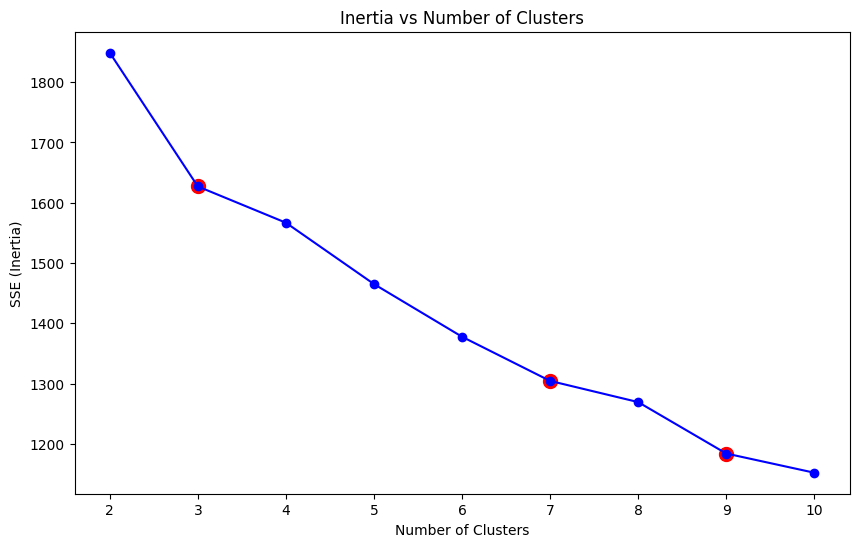

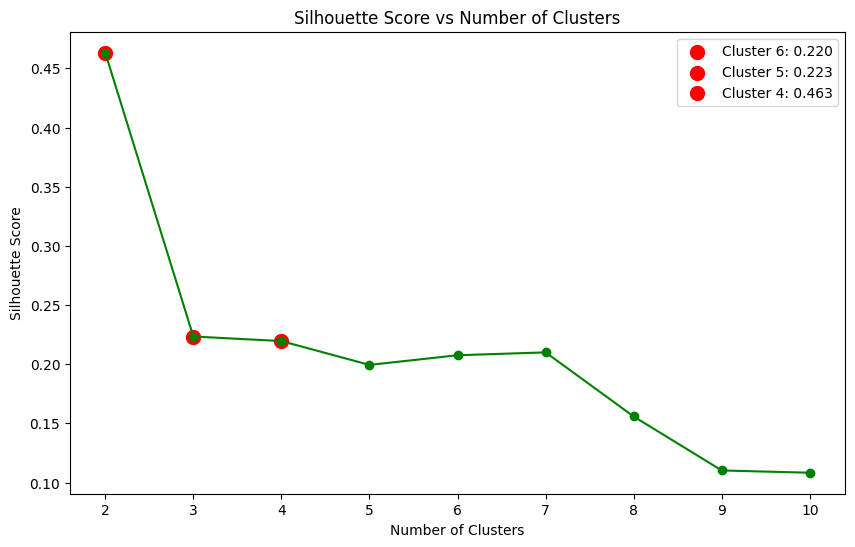

In [66]:
X, vectorizer = vectorize_constituency_trees(insertion_df)
determine_optimal_clusters(X, max_clusters=10)

## Clustering

In [81]:
clustered_df, kmeans_model, vectorizer = perform_clustering(insertion_df, num_clusters=4)

# Semantic elaboration example

In [43]:
import pandas as pd
example_df = pd.read_csv("../data/elaborations/example.csv")

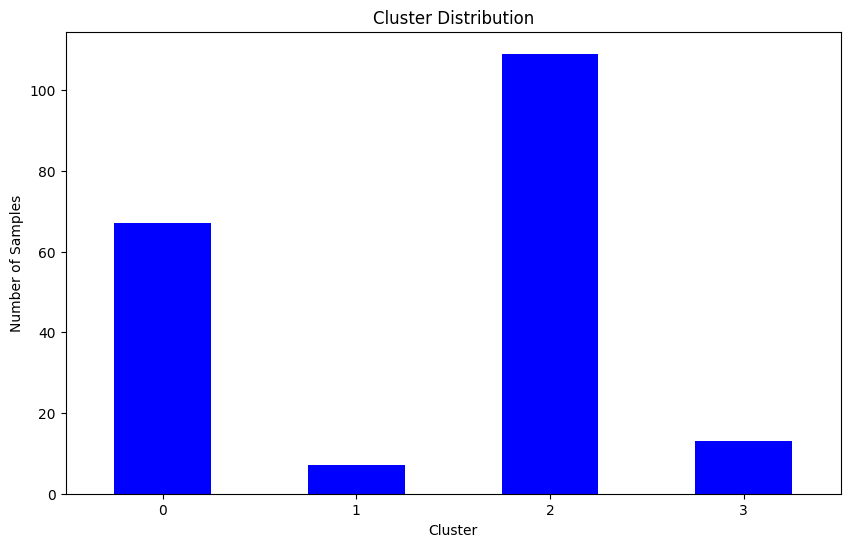

In [82]:
plot_cluster_distribution(clustered_df)

In [94]:
get_random_samples_per_cluster(clustered_df, num_samples=5)

Cluster 2:

1) Insertion: writes about
(ROOT (S (VP (VBZ writes) (PP (IN about)))))

2) Insertion: is usually seen in Churches and Cathedrals
(ROOT (S (VP (VBZ is) (ADVP (RB usually)) (VP (VBN seen) (PP (IN in) (NP (NNPS Churches) (CC and) (NNPS Cathedrals)))))))

3) Insertion: there will
(ROOT (S (NP (EX there)) (VP (MD will))))

4) Insertion: plants
(ROOT (NP (NNS plants)))

5) Insertion: the other
(ROOT (NP (DT the) (JJ other)))

Cluster 3:

1) Insertion: machine for making a point at the end of a
(ROOT (NP (NP (NN machine)) (PP (IN for) (S (VP (VBG making) (NP (DT a) (NN point)) (PP (IN at) (NP (NP (DT the) (NN end)) (PP (IN of) (NP (DT a))))))))))

2) Insertion:  The name TaeTiSeo is a portmanteau of the girls' names
(ROOT (S (NP (NP (DT The) (NN name)) (NP (NNP TaeTiSeo))) (VP (VBZ is) (NP (NP (DT a) (NN portmanteau)) (PP (IN of) (NP (NP (DT the) (NNS girls) (POS ')) (NNS names)))))))

3) Insertion: song has 4 beats per bar at 100 BPM
(ROOT (S (NP (NN song)) (VP (VBZ has) (NP (NP

# Semantic elaboration background

# Semantic elaboration generic